# Chapter 18: Smoothing Methods

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

In [1]:
%matplotlib inline
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools
from statsmodels.tsa.holtwinters import ExponentialSmoothing


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Create the graph
def singleGraphLayout(ax, ylim, train_df, valid_df):
    ax.set_xlim('1990', '2004-6')
    ax.set_ylim(*ylim)
    ax.set_xlabel('Time')
    one_month = pd.Timedelta('31 days')
    xtrain = (min(train_df.index), max(train_df.index) - one_month)
    xvalid = (min(valid_df.index) + one_month, max(valid_df.index) - one_month)
    xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])

    ypos = 0.9 * ylim[1] + 0.1 * ylim[0]
    ax.add_line(plt.Line2D(xtrain, (ypos, ypos), color='black', linewidth=0.5))
    ax.add_line(plt.Line2D(xvalid, (ypos, ypos), color='black', linewidth=0.5))
    ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)

    ypos = 0.925 * ylim[1] + 0.075 * ylim[0]
    ax.text('1995', ypos, 'Training')
    ax.text('2002-3', ypos, 'Validation')

def graphLayout(axes, train_df, valid_df):
    singleGraphLayout(axes[0], [1300, 2550], train_df, valid_df)
    singleGraphLayout(axes[1], [-550, 550], train_df, valid_df)
    train_df.plot(y='Ridership', ax=axes[0], color='C0', linewidth=0.75)
    valid_df.plot(y='Ridership', ax=axes[0], color='C0', linestyle='dashed', linewidth=0.75)
    axes[1].axhline(y=0, xmin=0, xmax=1, color='black', linewidth=0.5)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Ridership (in 000s)')
    axes[1].set_ylabel('Forecast Errors')
    if axes[0].get_legend(): 
        axes[0].get_legend().remove()

## Figure 18.2

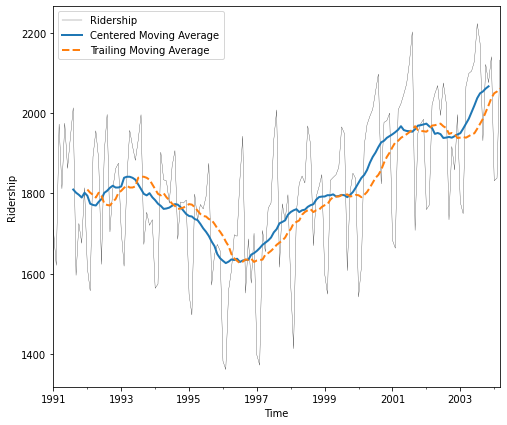

In [3]:
# Load data and convert to time series
Amtrak_df = pd.read_csv('https://raw.githubusercontent.com/borisgarbuzov/Business-apps/main/Data/Amtrak.csv')
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Month, format='%d/%m/%Y')
ridership_ts = pd.Series(Amtrak_df.Ridership.values, index=Amtrak_df.Date, name='Ridership')
ridership_ts.index = pd.DatetimeIndex(ridership_ts.index, freq=ridership_ts.index.inferred_freq)

# centered moving average with window size = 12
ma_centered = ridership_ts.rolling(12, center=True).mean()

# trailing moving average with window size = 12
ma_trailing = ridership_ts.rolling(12).mean()

# shift the average by one time unit
ma_centered = pd.Series(ma_centered[:-1].values, index=ma_centered.index[1:])
ma_trailing = pd.Series(ma_trailing[:-1].values, index=ma_trailing.index[1:])

fig, ax = plt.subplots(figsize=(8, 7))
ax = ridership_ts.plot(ax=ax, color='black', linewidth=0.25)
ma_centered.plot(ax=ax, linewidth=2)
ma_trailing.plot(ax=ax, style='--', linewidth=2)
ax.set_xlabel('Time')
ax.set_ylabel('Ridership')
ax.legend(['Ridership', 'Centered Moving Average', 'Trailing Moving Average'])

plt.show()

## Figure 18.3

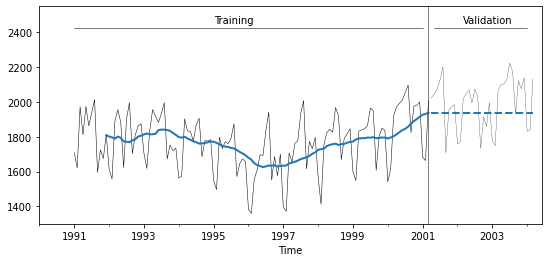

In [4]:
# partition the data
nValid = 36
nTrain = len(ridership_ts) - nValid

train_ts = ridership_ts[:nTrain]
valid_ts = ridership_ts[nTrain:]

# moving average on training
ma_trailing = train_ts.rolling(12).mean()
last_ma = ma_trailing[-1]

# create forecast based on last moving average in the training period
ma_trailing_pred = pd.Series(last_ma, index=valid_ts.index)

fig, ax = plt.subplots(figsize=(9,4))
train_ts.plot(ax=ax, color='black', linewidth=0.5)
valid_ts.plot(ax=ax, color='black', linewidth=0.25)
ma_trailing.plot(ax=ax, linewidth=2, color='C0')
ma_trailing_pred.plot(ax=ax, style='--', linewidth=2, color='C0')
singleGraphLayout(ax, [1300, 2550], train_ts, valid_ts)

plt.show()

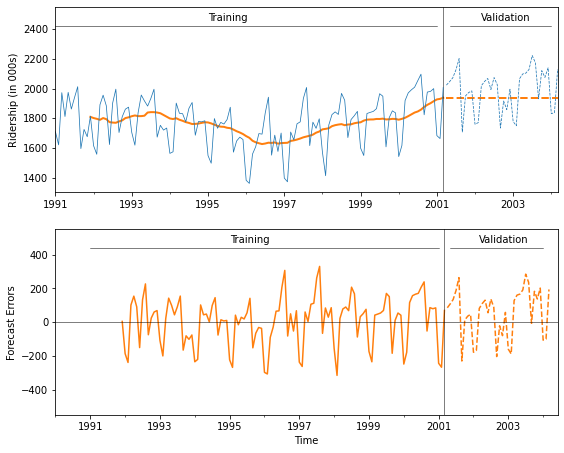

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))

ma_trailing.plot(ax=axes[0], linewidth=2, color='C1')
ma_trailing_pred.plot(ax=axes[0], linewidth=2, color='C1', linestyle='dashed')

residual = train_ts - ma_trailing
residual.plot(ax=axes[1], color='C1')
residual = valid_ts - ma_trailing_pred
residual.plot(ax=axes[1], color='C1', linestyle='dashed')

graphLayout(axes, train_ts, valid_ts)

plt.show()

## Table 18.1

In [6]:
# Build a model with seasonality, trend, and quadratic trend
ridership_df = tsatools.add_trend(ridership_ts, trend='ct')
ridership_df['Month'] = ridership_df.index.month

# partition the data
train_df = ridership_df[:nTrain]
valid_df = ridership_df[nTrain:]

formula = 'Ridership ~ trend + np.square(trend) + C(Month)'
ridership_lm_trendseason = sm.ols(formula=formula, data=train_df).fit()

# create single-point forecast
ridership_prediction = ridership_lm_trendseason.predict(valid_df.iloc[0, :])

# apply MA to residuals
ma_trailing = ridership_lm_trendseason.resid.rolling(12).mean()

print('Prediction', ridership_prediction[0])
print('ma_trailing', ma_trailing[-1])

Prediction 2004.2708927644014
ma_trailing 30.78068462414804


## Figure 18.4

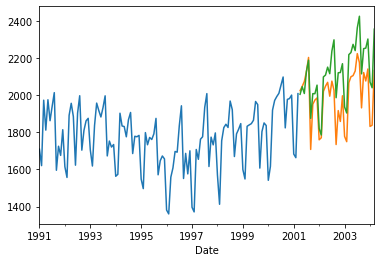

In [7]:
ax = train_df.Ridership.plot()
valid_df.Ridership.plot(ax=ax)
ridership_lm_trendseason.predict(valid_df).plot(ax=ax)

In [8]:
# residuals_ts = ridership_lm_trendseason.resid

# ax = ridership_lm_trendseason.resid.plot(color='black', linewidth=0.5)
# ax.set_ylabel('Ridership')
# ax.set_xlabel('Time')
# ax.axhline(y=0, xmin=0, xmax=1, color='grey', linewidth=0.5)

# # run exponential smoothing
# # with smoothing level alpha = 0.2
# expSmooth = ExponentialSmoothing(residuals_ts, freq='MS')
# expSmoothFit = expSmooth.fit(smoothing_level=0.2)

# expSmoothFit.fittedvalues.plot(ax=ax)
# expSmoothFit.forecast(len(valid_ts)).plot(ax=ax, style='--', linewidth=2, color='C0')

# plt.show()

# print(expSmoothFit.forecast(1))

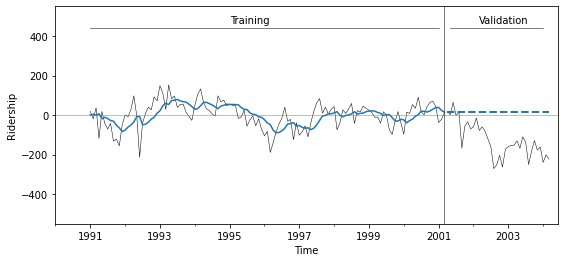

2001-04-01    14.142855
Freq: MS, dtype: float64


In [9]:
residuals_ts = ridership_lm_trendseason.resid
residuals_pred = valid_df.Ridership - ridership_lm_trendseason.predict(valid_df)


fig, ax = plt.subplots(figsize=(9,4))

ridership_lm_trendseason.resid.plot(ax=ax, color='black', linewidth=0.5)
residuals_pred.plot(ax=ax, color='black', linewidth=0.5)
ax.set_ylabel('Ridership')
ax.set_xlabel('Time')
ax.axhline(y=0, xmin=0, xmax=1, color='grey', linewidth=0.5)

# run exponential smoothing
# with smoothing level alpha = 0.2
expSmooth = ExponentialSmoothing(residuals_ts, freq='MS')
expSmoothFit = expSmooth.fit(smoothing_level=0.2)

expSmoothFit.fittedvalues.plot(ax=ax)
expSmoothFit.forecast(len(valid_ts)).plot(ax=ax, style='--', linewidth=2, color='C0')

singleGraphLayout(ax, [-550, 550], train_df, valid_df)

plt.show()

print(expSmoothFit.forecast(1))

In [10]:
# residuals_ts = ridership_lm_trendseason.resid

# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))

# ridership_lm_trendseason.predict(train_df).plot(ax=axes[0], linewidth=2, color='C1')
# ridership_lm_trendseason.predict(valid_df).plot(ax=axes[0], linewidth=1, color='C1')

# ridership_lm_trendseason.resid.plot(ax=axes[1], color='C1')
# residuals_pred = valid_df.Ridership - ridership_lm_trendseason.predict(valid_df)
# residuals_pred.plot(ax=axes[1], color='C1', linestyle='dashed')


# # run exponential smoothing
# # with smoothing level alpha = 0.2
# expSmooth = ExponentialSmoothing(residuals_ts, freq='MS')
# expSmoothFit = expSmooth.fit(smoothing_level=0.2)
# expSmoothForecast = expSmoothFit.forecast(len(valid_ts))

# expSmoothFit.fittedvalues.plot(ax=axes[1], color='C2')
# expSmoothForecast.plot(ax=axes[1], linewidth=2, color='C2', linestyle='dashed')

# correctedRidership_lm_trendseason = ridership_lm_trendseason.predict(valid_df) - expSmoothForecast
# correctedRidership_lm_trendseason.plot(ax=axes[0], linewidth=0.5, color='C2')


# graphLayout(axes, train_ts, valid_ts)


# plt.show()

# print(expSmoothFit.forecast(1))

# Figure 18.5

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


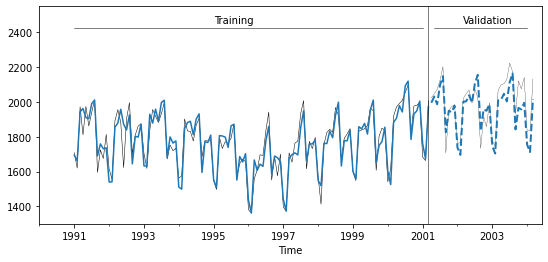

In [11]:
# run exponential smoothing with additive trend and additive seasonal
expSmooth = ExponentialSmoothing(train_ts, trend='additive', seasonal='additive', seasonal_periods=12, freq='MS')
expSmoothFit = expSmooth.fit()

fig, ax = plt.subplots(figsize=(9,4))
train_ts.plot(ax=ax, color='black', linewidth=0.5)
valid_ts.plot(ax=ax, color='black', linewidth=0.25)

expSmoothFit.fittedvalues.plot(ax=ax)
expSmoothFit.forecast(len(valid_ts)).plot(ax=ax, style='--', linewidth=2, color='C0')
singleGraphLayout(ax, [1300, 2550], train_ts, valid_ts)

plt.show()

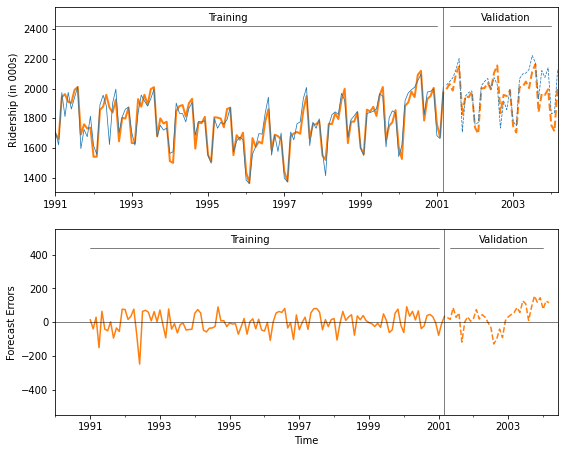

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))

expSmoothFit.fittedvalues.plot(ax=axes[0], linewidth=2, color='C1')
expSmoothFit.forecast(len(valid_ts)).plot(ax=axes[0], linewidth=2, color='C1', linestyle='dashed')

residual = train_ts - expSmoothFit.fittedvalues
residual.plot(ax=axes[1], color='C1')
residual = valid_ts - expSmoothFit.forecast(len(valid_ts))
residual.plot(ax=axes[1], color='C1', linestyle='dashed')

graphLayout(axes, train_ts, valid_ts)

plt.show()

## Table 18.2

In [13]:
expSmoothFit.params

{'damping_slope': nan,
 'initial_level': 1664.7331979818327,
 'initial_seasons': array([ 29.49435108, -13.36717915, 291.34703333, 293.42537392,
        327.77383273, 283.23005039, 393.77060569, 442.90718306,
        120.14619076, 243.14777081, 234.21640519, 271.19536306]),
 'initial_slope': 0.6812262102441621,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.5770095892233283,
 'smoothing_seasonal': 0.0,
 'smoothing_slope': 5.564839602455444e-48,
 'use_boxcox': False}

In [14]:
print('AIC: ', expSmoothFit.aic)
print('AICc: ', expSmoothFit.aicc)
print('BIC: ', expSmoothFit.bic)

AIC:  1021.8231535836505
AICc:  1028.4000766605736
BIC:  1066.8181032696093
